In [231]:
using LinearAlgebra
using PyPlot
using ControlSystems

In [232]:
#1D Double-Integrator Problem
N = 15
n = 2
m = 1
x0 = [1.0; 0]
dt = 1.0
A = [1 dt; 0 1];
B = [0.5*dt*dt; dt];

In [233]:
#LQR Cost Matrices
Q = Array(1.0*I(2))
R = Array(0.1*I(1))
#Qf = Array(1.0*I(2));
Qf = dare(A,B,Q,R); #This makes sure that the infinite-horizon K is the solution to the finite-horizon problem

In [234]:
#Cost Function
function cost(xtraj,utraj,Q,R,Qf)
    J = 0.0
    for k = 1:(N-1)
        J += 0.5*xtraj[:,k]'*Q*xtraj[:,k] + 0.5*(utraj[k]'*R*utraj[k])[1]
    end
    J += 0.5*xtraj[:,N]'*Qf*xtraj[:,N]
end

cost (generic function with 1 method)

In [235]:
#Groud Truth Solution (Infinite-Horizon LQR Gain)
K_true = dlqr(A,B,Q,R)

1×2 Matrix{Float64}:
 0.616695  1.27032

In [236]:
#Ground-truth Closed-loop simulation with LQR controller

function rollout!(xtraj,utraj,vtraj,x0,K,V,W)
    xtraj[:,1] .= x0
    for k = 1:(N-1)
        vtraj[k] = sqrt(V)*randn()
        utraj[k] = (-K*xtraj[:,k])[1] + vtraj[k]
        xtraj[:,k+1] .= A*xtraj[:,k] + B*utraj[k] + sqrt(W)*randn(2)
    end
end
    
xtraj_true = zeros(n,N)
utraj_true = zeros(N-1)
vtraj_true = zeros(N-1)

rollout!(xtraj_true,utraj_true,vtraj_true,x0,K_true,0,zeros(2,2))

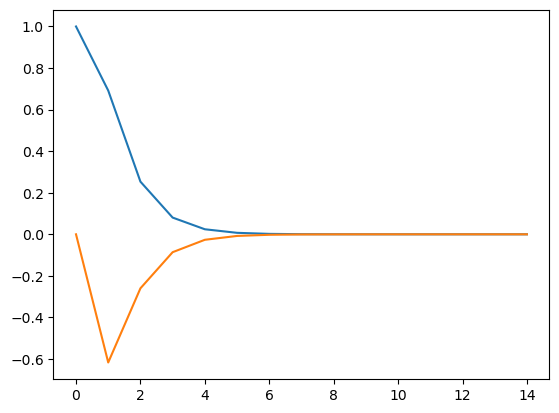

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e20d3d00>

In [237]:
plot(xtraj_true[1,:])
plot(xtraj_true[2,:])

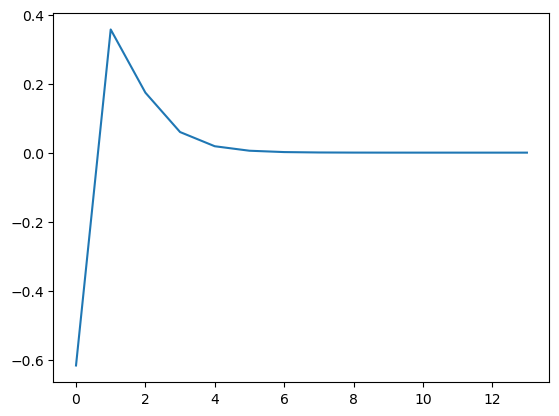

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e213d5e0>

In [238]:
plot(utraj_true)

In [250]:
#Policy-Gradient Algorithm
iter = 1000 #number of outer-loop iterations
batch_size = 50 #number of rollouts per minibatch to estimate policy gradient

α0 = 0.05 #step size ("learning rate")
β1 = 0.9
β2 = 0.999
ϵ = 1e-8

V = 0.01 #noise covariance for policy ("exploration")
W = zeros(2,2) #noise covariance for dynamics (process noise)

K0 = zeros(1,2)
K = deepcopy(K0)
baseline = 0.0
iter_costs = zeros(iter)
batch_costs = zeros(batch_size)
batch_vxt = zeros(1,2,batch_size)

adam_m = zeros(1,2)
adam_v = zeros(1,2)

xtraj_pg = zeros(2,N)
utraj_pg = zeros(N-1)
vtraj_pg = zeros(N-1);

In [243]:
#Vanilla SGD
for k = 1:iter
    
    #Do a bunch of rollouts with stochastic policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,V,W)
        batch_costs[j] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
        batch_vxt[:,:,j] .= vtraj_pg'*xtraj_pg[:,1:N-1]'
    end
    
    #Evaluate policy gradient from batch
    grad = zeros(1,2)
    for j = 1:batch_size
        grad -= ((batch_costs[j]-baseline)/batch_size)*batch_vxt[:,:,j]
    end
    baseline = (1.0/batch_size)*sum(batch_costs) #use average cost as baseline
    
    #Take gradient step on K
    K -= α0*grad
    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,0,zeros(2,2))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
end

In [251]:
#ADAM
for k = 1:iter
    
    #Do a bunch of rollouts with stochastic policy
    for j = 1:batch_size
        rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,V,W)
        batch_costs[j] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
        batch_vxt[:,:,j] .= vtraj_pg'*xtraj_pg[:,1:N-1]'
    end
    
    #Evaluate policy gradient from batch
    grad = zeros(1,2)
    for j = 1:batch_size
        grad -= ((batch_costs[j]-baseline)/batch_size)*batch_vxt[:,:,j]
    end
    baseline = (1.0/batch_size)*sum(batch_costs) #use average cost as baseline
    
    #Take ADAM step
    adam_m = β1*adam_m + (1-β1)*grad
    adam_v = β2*adam_v + (1-β2)*(grad.*grad)
    
    α = α0*sqrt(1-β2^(k+1))/(1-β1^(k+1))
    
    K -= α*adam_m./(sqrt.(adam_v).+ϵ)
    
    #Evaluate cost for plotting
    rollout!(xtraj_pg,utraj_pg,vtraj_pg,x0,K,0,zeros(2,2))
    iter_costs[k] = cost(xtraj_pg,utraj_pg,Q,R,Qf)
end

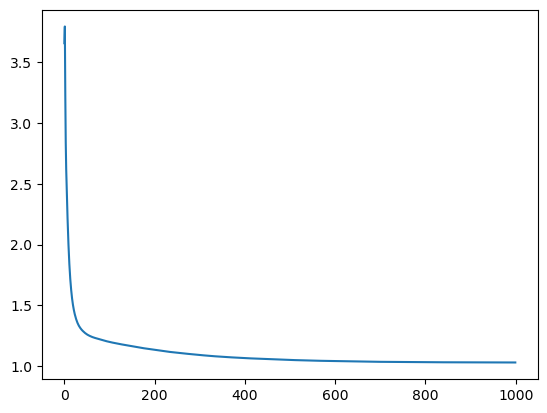

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e22d8c70>

In [252]:
plot(iter_costs)

In [253]:
true_cost = cost(xtraj_true,utraj_true,Q,R,Qf)

1.0299384521582335

In [254]:
iter_costs[end]

1.0302959775600002

In [255]:
K_true

1×2 Matrix{Float64}:
 0.616695  1.27032

In [256]:
K

1×2 Matrix{Float64}:
 0.600255  1.25325

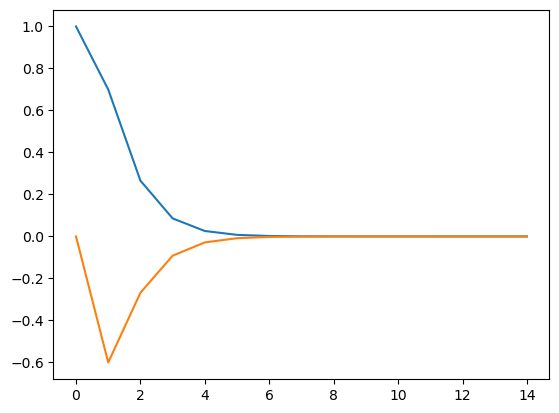

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1e23409d0>

In [257]:
plot(xtraj_pg[1,:])
plot(xtraj_pg[2,:])